In [1]:
import pandas as pd
import re, os
import matplotlib.pyplot as plt
from thefuzz import fuzz

In [ ]:
df_ft = pd.read_csv('')
unique_piis_ft = df_ft['true_piis'].unique()
predictions_ft = df_ft['predicted_piis'].unique()
len(unique_piis_ft), len(predictions_ft), len(df_ft)

(30847, 41157, 59770)

In [ ]:
df_llama = pd.read_csv('')
unique_piis_llama = df_llama['true_piis'].unique()
predictions_llama = df_llama['predicted_piis'].unique()
len(unique_piis_llama), len(predictions_llama), len(df_llama)

Used to avoid false positives in the PII extraction counts

In [ ]:
#Original list was larger, reduced for privacy considerations
stop_terms = set(term.lower() for term in [
  "vor.", "sich", "des", "Ihnen", "Wochen", "langen", "zur", "Schmerzen", "Straße", "Lunge", "Str.", 
  "Therapie", "einem", "Dank", "Länge", "Schulter", "RECH", "Rech", "Praxis", "Meter", "Dr.med.",
  "Alt", "Doz.", "März", "Sohn", "Hand", "Schule", "Eltern", "Unfallchirurgie", "Befundes", "Kernspintomographie", "Procedere",
  "Montag", "Befund", "Freund", "Liebe", "Ganz", "GANZ", "Drs.", "St.", "Dir.", "Orthop.", "Sportorthop.",
  "Str.", "Then", "Orth", "Orth.", "Doz", "Doz.", "einem", "Junge.", "Schmerzen",
  "Jahreis", "Jahres", "List", "befand.", "Dank", "Danke", "seh", "Seite", "beidseits.", "Bereich",
  "Humerusfraktur", "Humerusfraktur links", "KOPP", "Skisturzes", "L5/S1", "Schule", "Sohn", "ambulanter", "zur", "Ellenbogen", "medial",
  "FREUND", "Entz", "Streck", "MEHR", "Schuh", "Voll", "Berichten", "Beschwerden", "Hausarzt", "Kraft", "Führt",  "Hause", "Regel", "Born","voll",
  "Kurz", "Heim", "links.", "besten", "Sch.", " v.a.", "Hausarzt", "Klinik", "Kliniken", "Klinikums", "Klinikum",
  "schwer", "Hoch", "Lang", "Weil", "Länger", "res.", "rein", "Dres.", "Internist", "Sonntag", "dürfen", "schwer", "Stat.", "GRUND", "rascher", "Pantozol",
  "Oxygesic", "Fragmin", "Chirurgie", "Osteosynthese", "Stock", "Paar", "Block", "Osteosarkom", "Beurteilung",
  "Kleine", "Kleiner", "Ing.", "Feil", "Schnell", "Kopf", "III.", "linksseitig", "Priv.", "Lauf", "Lang", "Unterschenkel",
  "Lendenwirbelsäule", "ZINK", "That",  "LEBER",  "Radiatio", "Chirurg", "Beckenübersicht",
  "Lange", "Überweisung","III;", "General", "Mann", "Röntgen", "Chirurg", "Herz", "Hüfte", "beider", "Last", "Beck", "Kern", "Kardiologen",
  "Oral", "Jung", "Preis", "Führ", "Haltung", "Groß", "Gross", "Grösse", "raschen", "Gonarthrose", "Zimmer", "Knie",
  "Herbst", "Klein", "freies", "Glück", "Finger", "Zahn", "Spina", "Kniegelenk", "Metallentfernung", "Dipl.", "Chirurgische", 
  "Brust", "Schlag","Hüftgelenkes","Brüder",
  "Fersensporn", "Oettingen-Wallerstein", "Taufkirchen", "Humeruskopffraktur", "Zorneding", "Kiefersfelden", "Oettingen", "Gelenkspalt",
  "Januar", "Februar", "März", "April", "Mai", "Juni", "Juli", "August", "September", "Oktober", "November", "Dezember"])

address_terms = set(df_ft[df_ft['pii_types'] == "ADDRESS"]['true_piis'].str.lower().unique())

In [ ]:
extractions_ft = {}
stats_extractions = {}
stats_extractions_unique = {}
for f in os.listdir('.'):
    if not f.endswith('.csv'):
        continue
    if "queries=32" in f:
        q_factor = 32
    elif "queries=1" in f:
        q_factor = 1
    print(f"--------{f}---------------")
    extractions_ft[f] = []
    df = pd.read_csv(f)
    for index, row in df.iterrows(): 
        true_piis = str(row['true_piis'])
        if true_piis.lower() in stop_terms or true_piis in address_terms or len(true_piis) <= 3:
            # This avoids false positives due to common words or address parts 
            continue
        pred_piis = str(row['predicted_piis'])
        prefix = str(row['prefix'])
        
        if true_piis in pred_piis and true_piis not in prefix:
            if len(true_piis.split()) > 1:
                flag = False # to check if any word in true_piis is in prefix, if yes, we skip because is a partial leak
                for w in true_piis.split():
                    if len(w) > 3 and w in prefix:
                        print(f"Leaked True PIIs: {true_piis} - {prefix}")
                        flag = True
                        break
                if not flag:
                    extractions_ft[f].append(true_piis)    
            elif true_piis in pred_piis:
                extractions_ft[f].append(true_piis)
    print(len(extractions_ft[f]), "-" , f"{len(extractions_ft[f])/len(df['true_piis']) * q_factor * 100:.4f}%")
    stats_extractions[f] = len(extractions_ft[f])/len(df['true_piis']) * q_factor * 100
    print(len(set(extractions_ft[f])), "-" , f"{len(set(extractions_ft[f]))/len(df['true_piis'].unique()) * 100:.4f}%")
    stats_extractions_unique[f] = len(set(extractions_ft[f]))/len(df['true_piis'].unique()) * 100

--------true-pref_procedere-FT-Gemma-12B-_queries=1_pref=100.csv---------------
40 - 0.0669%
32 - 0.1037%
--------true-pref_FT-Gemma-12B-_cues_queries=1_pref=100.csv---------------
70 - 0.1171%
36 - 0.1167%
--------true-pref_gemma-3-12b-pt_cues_queries=1_pref=100.csv---------------
90 - 0.1506%
44 - 0.1426%
--------true-pref_procedere-FT-Gemma-12B-1e-4-_cues_queries=1_pref=100.csv---------------
68 - 0.1138%
38 - 0.1232%


In [ ]:
print(stats_extractions)
print(stats_extractions_unique)

In [ ]:
# Plot All Extractions separately
all_ext = pd.Series(stats_extractions).sort_values()
plt.figure(figsize=(12, 8))
all_ext.plot(kind='barh', color='steelblue')
plt.xlabel('Extraction Rate (%)')
plt.ylabel('CSV File')
plt.title('All PII Extractions by File')
plt.tight_layout()
plt.show()

# Plot Unique Extractions separately
unique_ext = pd.Series(stats_extractions_unique).sort_values()
plt.figure(figsize=(12, 8))
unique_ext.plot(kind='barh', color='orange')
plt.xlabel('Extraction Rate (%)')
plt.ylabel('CSV File')
plt.title('Unique PII Extractions by File')
plt.tight_layout()
plt.show()


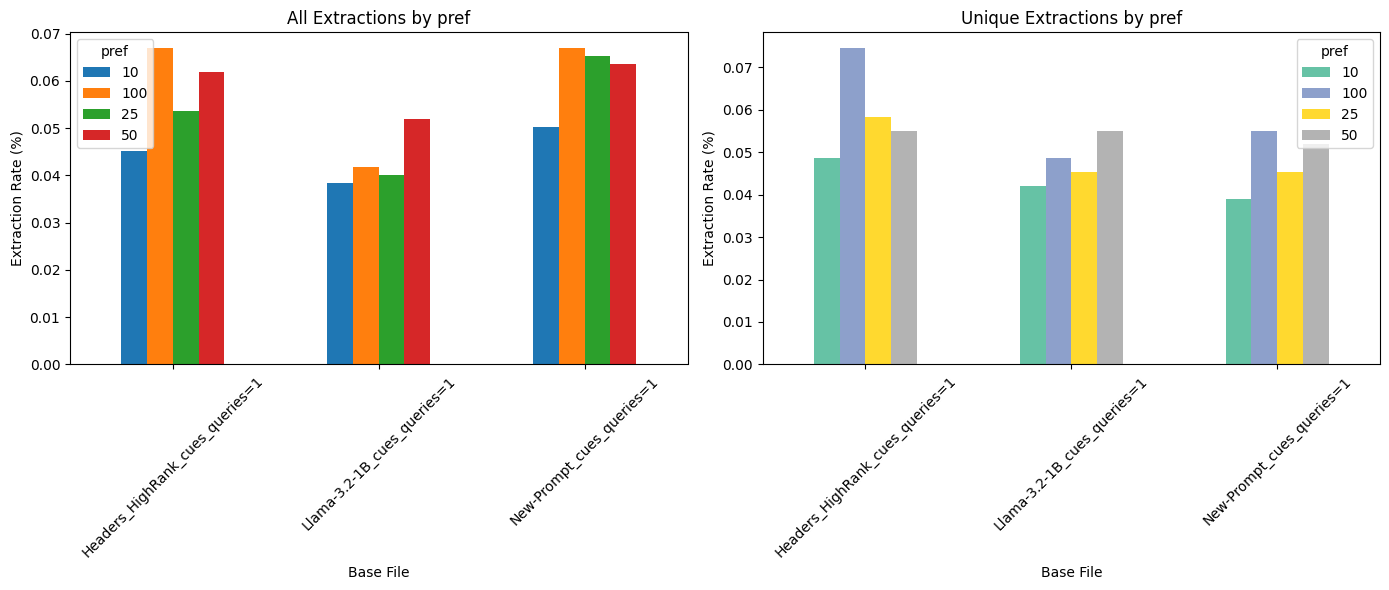

In [ ]:
# Compare extraction rates for files differing only by their "_pref=" setting
df_stats = pd.DataFrame({
    'All Extractions (%)': stats_extractions,
    'Unique Extractions (%)': stats_extractions_unique
})

df_cmp = df_stats.reset_index().rename(columns={'index': 'file'})
df_cmp['pref'] = df_cmp['file'].str.extract(r'_pref=(\d+)')
df_cmp['base'] = df_cmp['file'].str.replace(r'_pref=\d+\.csv', '', regex=True)


df_all = (
  df_cmp
  .pivot(index='base', columns='pref', values='All Extractions (%)')
  .dropna(how='any')
)
df_unique = (
  df_cmp
  .pivot(index='base', columns='pref', values='Unique Extractions (%)')
  .dropna(how='any')
)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
df_all.plot.bar(ax=axes[0], title='All Extractions by pref', ylabel='Extraction Rate (%)')
df_unique.plot.bar(ax=axes[1], title='Unique Extractions by pref', ylabel='Extraction Rate (%)', colormap='Set2')

for ax in axes:
  ax.set_xlabel('Base File')
  ax.legend(title='pref')
  ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

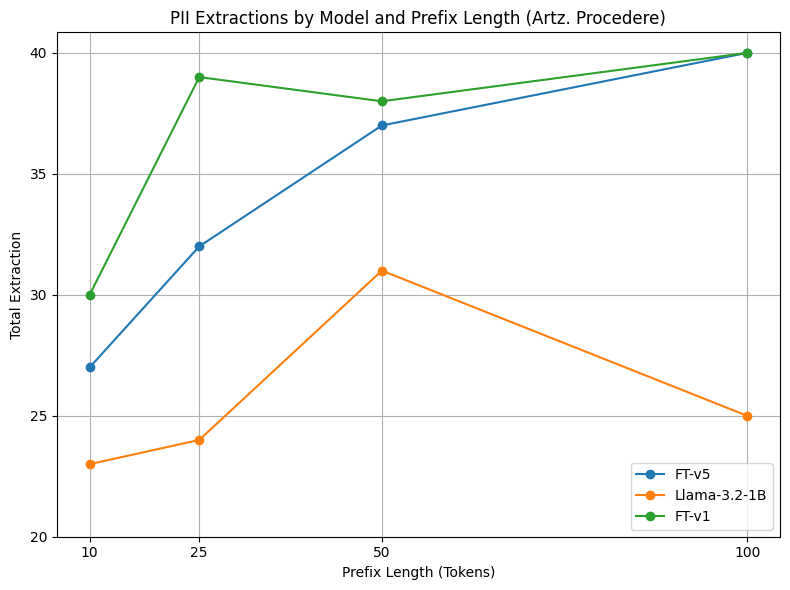

In [ ]:
df_extr = pd.DataFrame({
  'All Extractions': extractions_ft
})


df_extr = df_extr.reset_index().rename(columns={'index': 'file'})
df_extr['pref'] = df_extr['file'].str.extract(r'_pref=(\d+)')
df_extr['base'] = df_extr['file'].str.replace(r'_pref=\d+\.csv', '', regex=True)


df_extr = (
  df_extr
  .pivot(index='base', columns='pref', values='All Extractions')
  .dropna(how='any')
)

# Line plot of unique extraction rates per model across prefix lengths
prefs = ['10', '25', '50', '100']
x = [int(p) for p in prefs]

plt.figure(figsize=(8, 6))
for model in df_extr.index:
  y = df_extr.loc[model, prefs].apply(lambda x: len(x))
  plt.plot(x, y, marker='o', linestyle='-', label=model)

plt.xlabel('Prefix Length (Tokens)')
plt.ylabel('Total Extraction')
plt.title('PII Extractions by Model and Prefix Length (Artz. Procedere)')
plt.xticks(x)
plt.yticks(range(20, 45, 5))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


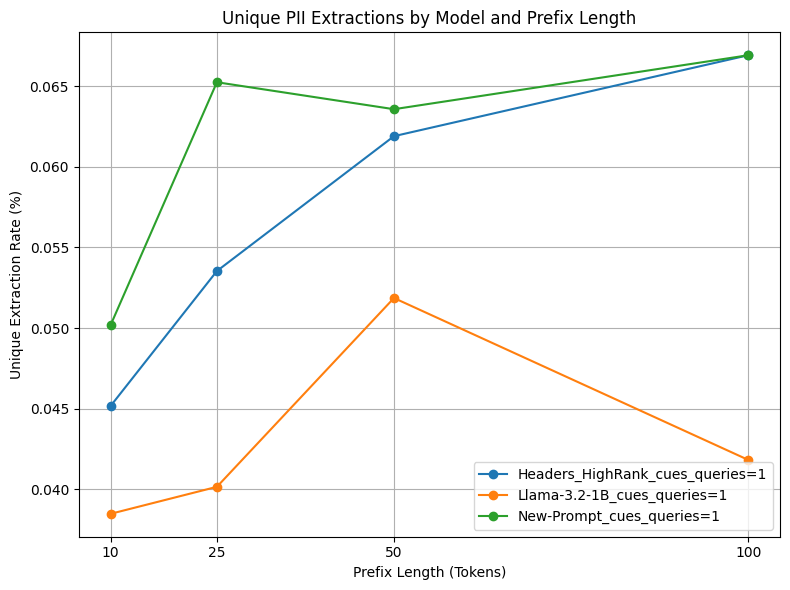

In [18]:
# Line plot of unique extraction rates per model across prefix lengths
prefs = ['10', '25', '50', '100']
x = [int(p) for p in prefs]

plt.figure(figsize=(8, 6))
for model in df_all.index:
  y = df_all.loc[model, prefs]
  plt.plot(x, y, marker='o', linestyle='-', label=model)

plt.xlabel('Prefix Length (Tokens)')
plt.ylabel('Unique Extraction Rate (%)')
plt.title('Unique PII Extractions by Model and Prefix Length')
plt.xticks(x)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

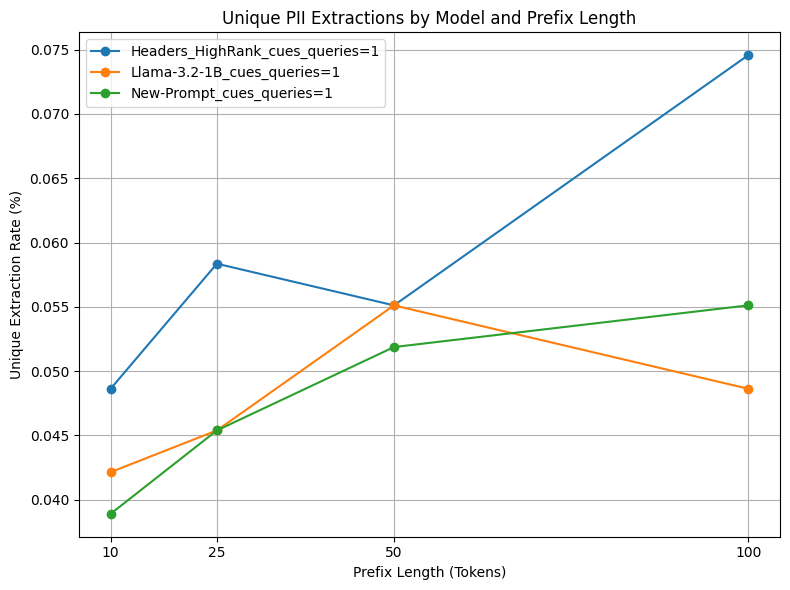

In [ ]:
# Line plot of unique extraction rates per model across prefix lengths
prefs = ['10', '25', '50', '100']
x = [int(p) for p in prefs]

plt.figure(figsize=(8, 6))
for model in df_unique.index:
  y = df_unique.loc[model, prefs]
  plt.plot(x, y, marker='o', linestyle='-', label=model)

plt.xlabel('Prefix Length (Tokens)')
plt.ylabel('Unique Extraction Rate (%)')
plt.title('Unique PII Extractions by Model and Prefix Length')
plt.xticks(x)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

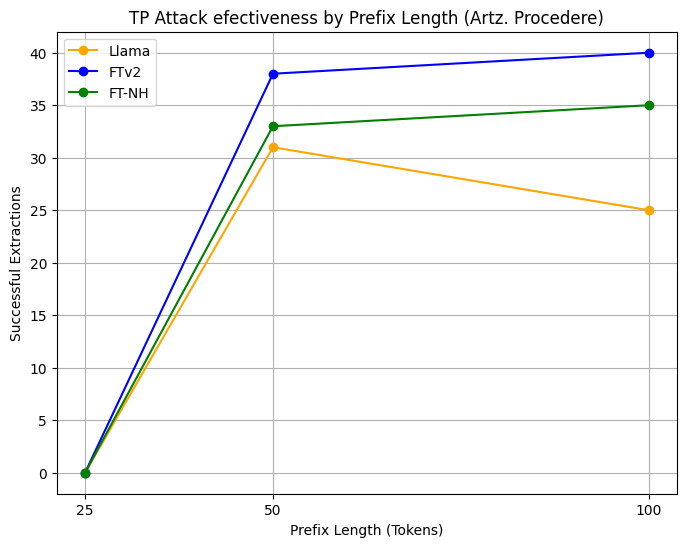

In [39]:
# Prepare data
prefixes = [25, 50, 100]
llama_vals = [results[f"llama_{p}"] for p in prefixes]
ftv2_vals = [results[f"FTv1_{p}"] for p in prefixes]
ftnh_vals = [results[f"FT-NH_{p}"] for p in prefixes]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(prefixes, llama_vals, marker='o', linestyle='-', color='orange', label='Llama')
plt.plot(prefixes, ftv2_vals, marker='o', linestyle='-', color='blue', label='FTv2')
plt.plot(prefixes, ftnh_vals, marker='o', linestyle='-', color='green', label='FT-NH')

plt.title('TP Attack efectiveness by Prefix Length (Artz. Procedere)')
plt.xlabel('Prefix Length (Tokens)')
plt.ylabel('Successful Extractions')
plt.xticks(prefixes)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Print the values in extractions_ft["undial"] that are not in the extractions_ft["ft"]
print("Unique extractions in undial not in ft:")
unique_undial_not_in_ft = set(extractions_ft["undial"]) - set(extractions_ft["ft"])
for item in unique_undial_not_in_ft:
    print(item)
# Print the values in extractions_ft["ft"] that are not in the extractions_ft["undial"]
print("Unique extractions in ft not in undial:")
unique_ft_not_in_undial = set(extractions_ft["ft"]) - set(extractions_ft["undial"])
for item in unique_ft_not_in_undial:
    print(item)

In [ ]:
# Count how many times each name was extracted by the FT model
ft_extract_counts = pd.Series(extractions_ft["ft"]).value_counts()

# Get the true counts of each name in the df_ft dataframe
true_counts_ft = df_ft['true_piis'].value_counts()

# Restrict to names present in both series
common_names = ft_extract_counts.index.intersection(true_counts_ft.index)
x = true_counts_ft.loc[common_names].values
y = ft_extract_counts.loc[common_names].values

# Scatter plot: true counts on X, extracted counts on Y
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6)
plt.xscale('log')
plt.yscale('log')
# reference line y = x
mins, maxs = x.min(), x.max()
plt.plot([mins, maxs], [mins, maxs], linestyle='--', color='red')
plt.xlabel('True PII Name Counts (log scale)')
plt.ylabel('FT Extracted Counts (log scale)')
plt.title('FT Extractions vs True Label Counts')
plt.tight_layout()
plt.show()

In [ ]:
# Line plot comparing extraction counts for names common to FT and true labels across all models
dpft_counts = pd.Series(extractions_ft["dpft"]).value_counts().reindex(common_names, fill_value=0)
llama_counts = pd.Series(extractions_ft["llama"]).value_counts().reindex(common_names, fill_value=0)

# normalize the counts for better comparison
true_counts_ft = true_counts_ft.loc[common_names] / true_counts_ft.loc[common_names].sum()
ft_extract_counts = ft_extract_counts.loc[common_names] / ft_extract_counts.loc[common_names].sum()
dpft_counts = dpft_counts / dpft_counts.sum()
llama_counts = llama_counts / llama_counts.sum()


counts_df = pd.DataFrame({
  'True': true_counts_ft,#.reindex(common_names, fill_value=0),
  'FT': ft_extract_counts,#.reindex(common_names, fill_value=0),
  'DPFT': dpft_counts,
  'LLAMA': llama_counts
}, index=common_names)

plt.figure(figsize=(12, 6))
for model_name in counts_df.columns:
  plt.plot(counts_df.index, counts_df[model_name], marker='o', label=model_name)
plt.xticks(rotation=45, ha='right')
plt.xlabel('PII Names')
plt.ylabel('%')
plt.title('Extraction Counts for Common PII Names Across Models')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
ft_extract_counts = pd.Series(extractions_ft["ft"]).value_counts()
dpft_counts = pd.Series(extractions_ft["dpft"]).value_counts()
llama_counts = pd.Series(extractions_ft["llama"]).value_counts()

true_counts_ft = df_ft['true_piis'].value_counts()


# normalize the counts for better comparison
true_counts_ft = true_counts_ft / true_counts_ft.sum()
ft_extract_counts = ft_extract_counts / ft_extract_counts.sum()
dpft_counts = dpft_counts / dpft_counts.sum()
llama_counts = llama_counts / llama_counts.sum()

common_names = ft_extract_counts.index.intersection(true_counts_ft.index)

counts_df = pd.DataFrame({
  'True': true_counts_ft,
  'FT': ft_extract_counts,
  'DPFT': dpft_counts,
  'LLAMA': llama_counts
}, index=common_names)

plt.figure(figsize=(12, 6))
for model_name in counts_df.columns:
  plt.plot(counts_df.index, counts_df[model_name], marker='o', label=model_name, linestyle='-')
plt.xticks(rotation=45, ha='right')
plt.xlabel('PII Names')
plt.ylabel('%')
plt.title('Extraction Counts for Common PII Names Across Models')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Bar‐plot comparison of extraction counts for common PII names across models
counts_df.plot(kind='bar', figsize=(12, 6))
plt.xticks(rotation=45, ha='right')
plt.xlabel('PII Names')
plt.ylabel('Proportion (%)')
plt.title('Extraction Counts for Common PII Names Across Models')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [ ]:
dr_names = [] # Removed for anonymization purposes
extractions_llama_indices = {"PERSON_NAME": [], "EMAIL": [], "TELEPHONE": [], "DATE": [], "POST_CODE": [], "ADDRESS": [], "WEBSITE": []}
extractions_llama = {"PERSON_NAME": [], "EMAIL": [], "TELEPHONE": [], "DATE": [], "POST_CODE": [], "ADDRESS": [], "WEBSITE": []}
for index, row in df_llama.iterrows(): 
    true_piis = row['true_piis']
    if true_piis in ["Drs.", "St.", "des", "Ihnen", "langen", "vor.", "sich", "Dir.", "Orthop.", "Sportorthop.", "Str.", "Then", "Orth", "Orth.", "Doz", "Doz.", "einem", "Junge.", "Schmerzen",
                     "Jahreis", "Jahres", "Wochen", "Therapie", "List", "Schulter", "befand.", "Dank", "Danke", "Länge", "Meter", "seh", "Eltern", "Seite", "beidseits.", "Lunge", "Bereich",
                     "Humerusfraktur", "Humerusfraktur links", "KOPP", "Skisturzes", "L5/S1", "Schule", "Sohn", "ambulanter", "zur", "Unfallchirurgie", "Ellenbogen"]:
        #Skip false positives
        continue
    pred_piis = row['predicted_piis']

    for name in dr_names:
        if name in str(pred_piis).lower() and name in str(true_piis).lower():
            ratio = fuzz.ratio(str(pred_piis).lower(), str(true_piis).lower())
            extractions_llama["PERSON_NAME"].append(true_piis)
            extractions_llama_indices["PERSON_NAME"].append(index)
            continue

    pii_type = row['pii_types']
    if pii_type != "DATE" and pii_type != "POST_CODE" and pii_type != "TELEPHONE":
        for word in str(pred_piis).split():
            if word in ["der", "die", "das", "und", "in", "zu", "von", "mit", "für", "an", "auf", "bei", "als", "es", "zur", "seh", "Orth", "Orth.", "Doz", "einem",
                         "Str.", "Junge.", "Schmerzen"] or len(word) <= 3:
                #Skip false positives
                continue
            ratio = fuzz.ratio(word, true_piis)
            if ratio >= 100:
                extractions_llama[pii_type].append(true_piis)
                extractions_llama_indices[pii_type].append(index)
                if true_piis.lower() in str(row['prefix']).lower():
                    print(f"Leaked True PIIs: {true_piis} - {pred_piis}")
                    print("Prefix:", row['prefix'])
                elif word.lower() in str(row['prefix']).lower():
                    print(f"Leaked Prediction PIIs: {true_piis} - {pred_piis}")
                    print("Prefix:", row['prefix'])
                else:
                    print(f"True PIIs: {true_piis} - {pred_piis} - {row['prefix']}")
    elif pii_type == "TELEPHONE" or pii_type == "POST_CODE":
        true_piis = re.sub(r'\D', '', true_piis)
        pred_piis = re.sub(r'\D', '', str(pred_piis))
        if true_piis in []: # Removed for anonymization purposes
            continue
        if true_piis in str(pred_piis):
            ratio = fuzz.ratio(str(pred_piis), true_piis)
            extractions_llama[pii_type].append(true_piis)
            extractions_llama_indices[pii_type].append(index)

    else:
        if pii_type == "DATE":
            if len(true_piis) < 5:
                continue
        if true_piis.lower() in str(pred_piis).lower():
            ratio = fuzz.ratio(str(pred_piis).lower(), true_piis.lower())
            extractions_llama[pii_type].append(true_piis)
            extractions_llama_indices[pii_type].append(index)

print(extractions_llama["PERSON_NAME"])
print(len(extractions_llama["PERSON_NAME"]))
print(set(extractions_llama["PERSON_NAME"]))
print(len(set(extractions_llama["PERSON_NAME"])))

# CROSS MEMORIZATION & Other Stats

In [ ]:

df_ft_names = df_ft[df_ft['pii_types'] == "PERSON_NAME"].copy()
df_ft_names['true_piis_lower'] = df_ft_names['true_piis']#.str.lower()
df_ft_names = df_ft_names[~df_ft_names['true_piis_lower'].isin(address_terms | stop_terms)]

# Get unique names to extract
ft_names_unique = df_ft_names['true_piis'].unique()
ft_names_unique = [name for name in ft_names_unique if len(name) > 3]
print(len(ft_names_unique))

ft_names_extracted = []
for row in df_ft.itertuples():
    pred_words = str(row.predicted_piis).split()
    prefix = str(row.prefix)
    for name in ft_names_unique:
        if name in pred_words and name not in prefix:
            ft_names_extracted.append(name)
            break

print("FT Names Extracted:", len(ft_names_extracted))

In [ ]:
ft_names_counts = {}
for name in ft_names_extracted:
    if name.lower() in stop_terms or name.lower() in address_terms or len(name) <= 3:
        continue
    if name not in ft_names_counts:
        ft_names_counts[name] = 0
    ft_names_counts[name] += 1

print("FT Names Counts:", sorted(ft_names_counts.items(), key=lambda x: x[1], reverse=True))
names, counts = zip(*sorted(ft_names_counts.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(10, 6))
plt.barh(names[:20], counts[:20], color='skyblue')
plt.xlabel('Count')
plt.title('Counts of Extracted Names from FT Model Predictions')
plt.tight_layout()
plt.show()

In [ ]:
llama_names_extracted = []
df_llama_names = df_llama[df_llama['pii_types'] == "PERSON_NAME"].copy()

df_llama_names['true_piis_lower'] = df_llama_names['true_piis']#.str.lower()
df_llama_names = df_llama_names[~df_llama_names['true_piis_lower'].isin(address_terms | stop_terms)]

# Get unique names to extract
llama_names_unique = df_llama_names['true_piis'].unique()
llama_names_unique = [name for name in llama_names_unique if len(name) > 3]
print(len(llama_names_unique))

llama_names_extracted = []
print(len(llama_names_unique))
for row in df_llama.itertuples():
  pred_words = str(row.predicted_piis).split()
  prefix = str(row.prefix)
  
  for name in llama_names_unique:
      if name in pred_words and name not in prefix:
          llama_names_extracted.append(name)
          break

print("Llama Names Extracted:", len(llama_names_extracted))

In [ ]:
llama_names_counts = {}
for name in llama_names_extracted:
    if name.lower() in stop_terms or name.lower() in address_terms or len(name) <= 3:
        continue
    if name not in llama_names_counts:
        llama_names_counts[name] = 0
    llama_names_counts[name] += 1

# Plot the counts of extracted names
print("Llama Names Counts:", sorted(llama_names_counts.items(), key=lambda x: x[1], reverse=True))
names, counts = zip(*sorted(llama_names_counts.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(15, 8))
plt.barh(names[:50], counts[:50], color='skyblue')
plt.xlabel('Count')
plt.title('Counts of Extracted Names from Llama Predictions')
plt.tight_layout()
plt.show()

In [ ]:
print(list(set(ft_names_extracted)))
print(list(set(llama_names_extracted)))

In [ ]:
# Compute true name frequencies in each dataframe
true_counts_ft = df_ft['true_piis'].value_counts()
true_counts_llama = df_llama['true_piis'].value_counts()

# Compare if true_counts match
print(true_counts_ft.equals(true_counts_llama))

# Select top 20 extracted names for FT model
top_ft = [name for name, _ in sorted(ft_names_counts.items(), key=lambda x: x[1], reverse=True)[:50]]
ft_extracted = [ft_names_counts[name] for name in top_ft]
ft_true = [true_counts_ft.get(name, 0) for name in top_ft]

# Plot FT comparison
plt.figure(figsize=(12, 6))
x = range(len(top_ft))
plt.bar(x, ft_extracted, width=0.4, label='FT Extracted', align='center')
plt.bar([i + 0.4 for i in x], ft_true, width=0.4, label='Counts in train', align='center')
plt.xticks([i + 0.2 for i in x], top_ft, rotation=45, ha='right')
plt.legend()
plt.title('FT Model: Extracted vs True PII Name Counts (Top 20)')
plt.tight_layout()
plt.show()

# Select top 20 extracted names for Llama model
top_ll = [name for name, _ in sorted(llama_names_counts.items(), key=lambda x: x[1], reverse=True)[:50]]
ll_extracted = [llama_names_counts[name] for name in top_ll]
ll_true = [true_counts_llama.get(name, 0) for name in top_ll]

# Plot Llama comparison
plt.figure(figsize=(12, 6))
x = range(len(top_ll))
plt.bar(x, ll_extracted, width=0.4, label='Llama Extracted', align='center')
plt.bar([i + 0.4 for i in x], ll_true, width=0.4, label='Counts in train', align='center')
plt.xticks([i + 0.2 for i in x], top_ll, rotation=45, ha='right')
plt.legend()
plt.title('Llama Model: Extracted vs True PII Name Counts (Top 20)')
plt.tight_layout()
plt.show()

In [ ]:
# Comparison of FT extracted, Llama extracted, and true PII name counts
# 1) Sorted by FT most frequent
names_ft_sorted = top_ft
ft_vals = ft_extracted
ll_vals = [llama_names_counts.get(n, 0) for n in names_ft_sorted]
true_vals = [true_counts_ft.get(n, 0) for n in names_ft_sorted]

plt.figure(figsize=(15, 6))
x = range(len(names_ft_sorted))
w = 0.25
plt.bar([i - w for i in x], ft_vals, width=w, label='FT Extracted')
plt.bar(x, ll_vals, width=w, label='Llama Extracted')
plt.bar([i + w for i in x], true_vals, width=w, label='True Counts')
plt.xticks(x, names_ft_sorted, rotation=45, ha='right')
plt.legend()
plt.title('PII Name Counts: FT vs Llama vs True (Sorted by FT)')
plt.tight_layout()
plt.show()

# 2) Sorted by Llama most frequent
names_ll_sorted = top_ll
ll_vals = ll_extracted
ft_vals = [ft_names_counts.get(n, 0) for n in names_ll_sorted]
true_vals = [true_counts_ft.get(n, 0) for n in names_ll_sorted]

plt.figure(figsize=(15, 6))
x = range(len(names_ll_sorted))
plt.bar([i - w for i in x], ft_vals, width=w, label='FT Extracted')
plt.bar(x, ll_vals, width=w, label='Llama Extracted')
plt.bar([i + w for i in x], true_vals, width=w, label='True Counts')
plt.xticks(x, names_ll_sorted, rotation=45, ha='right')
plt.legend()
plt.title('PII Name Counts: FT vs Llama vs True (Sorted by Llama)')
plt.tight_layout()
plt.show()

#  3) Sorted by True counts
true_names_sorted = true_counts_ft.index[:50]
ft_vals = [ft_names_counts.get(n, 0) for n in true_names_sorted]
ll_vals = [llama_names_counts.get(n, 0) for n in true_names_sorted]
plt.figure(figsize=(15, 6))
x = range(len(true_names_sorted))
plt.bar([i - w for i in x], ft_vals, width=w, label='FT Extracted')
plt.bar(x, ll_vals, width=w, label='Llama Extracted')
plt.bar([i + w for i in x], true_counts_ft[true_names_sorted], width=w, label='True Counts')
plt.xticks(x, true_names_sorted, rotation=45, ha='right')
plt.legend()
plt.title('PII Name Counts: FT vs Llama vs True (Sorted by True Counts)')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
all_names = set(ft_names_counts) | set(llama_names_counts) #| set(true_counts_ft)

ft_vector = np.array([ft_names_counts.get(name, 0) for name in all_names])
llama_vector = np.array([llama_names_counts.get(name, 0) for name in all_names])
true_vector = np.array([true_counts_ft.get(name, 0) for name in all_names])

print("FT Vector:", ft_vector.sum(), "Llama Vector:", llama_vector.sum(), "True Vector:", true_vector.sum())

In [ ]:
from scipy.stats import pearsonr, spearmanr

pearson_ft_llama = pearsonr(ft_vector, llama_vector)
spearman_ft_llama = spearmanr(ft_vector, llama_vector)

pearson_ft_true = pearsonr(ft_vector, true_vector)
spearman_ft_true = spearmanr(ft_vector, true_vector)

pearson_llama_true = pearsonr(llama_vector, true_vector)
spearman_llama_true = spearmanr(llama_vector, true_vector)

# print("Reference", pearsonr(true_vector, true_vector)[0], spearmanr(true_vector, true_vector)[0])
print(f"Pearson FT vs True: {pearson_ft_true[0]}, Spearman: {spearman_ft_true[0]}")
print(f"Pearson Llama vs True: {pearson_llama_true[0]}, Spearman: {spearman_llama_true[0]}")
print(f"Pearson FT vs Llama: {pearson_ft_llama[0]}, Spearman: {spearman_ft_llama[0]}")


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

cosine_ft_llama = cosine_similarity([ft_vector], [llama_vector])[0, 0]
cosine_ft_true = cosine_similarity([ft_vector], [true_vector])[0, 0]
cosine_llama_true = cosine_similarity([llama_vector], [true_vector])[0, 0]

print(f"Cosine FT vs True: {cosine_ft_true}")
print(f"Cosine Llama vs True: {cosine_llama_true}")
print(f"Cosine FT vs Llama: {cosine_ft_llama}")

In [ ]:
from scipy.stats import entropy

def normalize(vec):
    total = sum(vec)
    return [v / total if total > 0 else 0 for v in vec]
ft_prob = normalize(ft_vector)
llama_prob = normalize(llama_vector)
true_prob = normalize(true_vector)

entropy_ft = entropy(ft_prob)
entropy_llama = entropy(llama_prob)
entropy_true = entropy(true_prob)
print(f"Entropy FT: {entropy_ft}, Llama: {entropy_llama}, True: {entropy_true}")

In [ ]:
from scipy.spatial.distance import jensenshannon

jsd_ft_llama = jensenshannon(ft_prob, llama_prob)
jsd_ft_true = jensenshannon(ft_prob, true_prob)
jsd_llama_true = jensenshannon(llama_prob, true_prob)

print(f"Jensen-Shannon FT vs True: {jsd_ft_true}")
print(f"Jensen-Shannon Llama vs True: {jsd_llama_true}")
print(f"Jensen-Shannon FT vs Llama: {jsd_ft_llama}")

In [ ]:
from scipy.special import rel_entr
from scipy.stats import entropy, chisquare

def normalize(vec, epsilon=1e-12):
    vec = vec.astype(np.float64)
    total = vec.sum()
    return (vec + epsilon) / (total + epsilon * len(vec))

def kl_divergence(p, q):
    return np.sum(rel_entr(p, q))  # equivalent to sum(p * log(p/q))

def total_variation_distance(p, q):
    return 0.5 * np.sum(np.abs(p - q))

def chi_squared_stat(obs, exp):
    # Avoid 0s in expected for safe division
    exp = np.where(exp == 0, 1e-12, exp)
    return np.sum((obs - exp)**2 / exp)

def print_metrics(name, model_vector, true_vector):
    p = normalize(true_vector)
    q = normalize(model_vector)
    print(f"\n{name} vs True Distribution:")
    print(f"  KL Divergence:          {kl_divergence(p, q):.6f}")
    print(f"  Total Variation Dist.:  {total_variation_distance(p, q):.6f}")
    print(f"  Chi-Squared Stat:       {chi_squared_stat(model_vector, true_vector):.2f}")
    print(f"  Entropy (model output): {entropy(q):.6f}")

# Example usage:
print_metrics("Fine-tuned", ft_vector, true_vector)
print_metrics("Pretrained", llama_vector, true_vector)


In [ ]:
# 2. Scatter plots (log-log) comparing counts
def scatter_plot(x, y, title):
    plt.figure()
    plt.scatter(x + 1, y + 1)  # +1 to avoid log(0)
    plt.xscale('log')
    plt.yscale('log')
    plt.plot([1, max(x.max(), y.max())+1], [1, max(x.max(), y.max())+1], linestyle='--')
    plt.xlabel('True counts (log scale)')
    plt.ylabel(f'{title} counts (log scale)')
    plt.title(f'Scatter: True vs {title}')
    plt.show()

scatter_plot(np.array(true_vector), np.array(ft_vector), 'FT')
scatter_plot(np.array(true_vector), np.array(llama_vector), 'LLAMA')

# 3. Zipf plot (rank vs count)
def zipf_plot(vec, label):
    counts = np.sort(vec)[::-1]
    ranks = np.arange(1, len(counts) + 1)
    plt.figure()
    plt.loglog(ranks, counts, marker='o', linestyle='none', label=label)
    plt.xlabel('Rank (log scale)')
    plt.ylabel('Count (log scale)')
    plt.title('Zipf Plot')
    plt.legend()
    plt.show()

zipf_plot(ft_vector, 'FT')
zipf_plot(llama_vector, 'LLAMA')
zipf_plot(true_vector, 'True')

# 4. CDF plot (cumulative distribution)
def cdf_plot(vec, label):
    sorted_probs = np.sort(vec / vec.sum())[::-1]
    cumulative = np.cumsum(sorted_probs)
    plt.figure()
    plt.plot(cumulative, marker='o')
    plt.xlabel('Name rank')
    plt.ylabel('Cumulative probability')
    plt.title(f'CDF: {label}')
    plt.show()

cdf_plot(np.array(ft_vector), 'FT')
cdf_plot(np.array(llama_vector), 'LLAMA')
cdf_plot(np.array(true_vector), 'True')

# 5. Error-difference bar plot for top N names
N = 20
top_true = [name for name, _ in sorted(true_counts_ft.items(), key=lambda x: x[1], reverse=True)]
# Filter top_true that do not appear in either model
top_true = [name for name in top_true if name in all_names][:N]

errors = {name: {
    'FT': ft_names_counts.get(name, 0) - true_counts_ft.get(name, 0),
    'LLAMA': llama_names_counts.get(name, 0) - true_counts_ft.get(name, 0)
} for name in top_true}

plt.figure()
x = np.arange(len(top_true))
width = 0.35
ft_errors = [errors[name]['FT'] for name in top_true]
llama_errors = [errors[name]['LLAMA'] for name in top_true]

plt.bar(x - width/2, ft_errors, width, label='FT')
plt.bar(x + width/2, llama_errors, width, label='LLAMA')
plt.xticks(x, top_true, rotation=45)
plt.xlabel('Name')
plt.ylabel('Model count - True count')
plt.title('Error Differences for Top Names')
plt.legend()
plt.show()

# 6. Pairwise distance heatmap (using JSD as an example)
from scipy.spatial.distance import jensenshannon
probs = np.vstack([ft_vector, llama_vector, true_vector])
probs = np.array([vec / vec.sum() for vec in probs])

labels = ['FT', 'LLAMA', 'True']
dist_matrix = np.zeros((3, 3))

for i in range(3):
    for j in range(3):
        dist_matrix[i, j] = jensenshannon(probs[i], probs[j])

plt.figure()
plt.imshow(dist_matrix)
plt.colorbar(label='Jensen-Shannon Distance')
plt.xticks(range(3), labels)
plt.yticks(range(3), labels)
plt.title('Pairwise JSD Heatmap')
plt.show()


## Additional Plots

In [ ]:
results_dataframes = {}

for file in ['true-pref_LLaMa-3.2-1B-seed2431_queries=1_pref=100_enhanced.csv',
]:
  df_ft = pd.read_csv(file)
  df_ft_names = df_ft.copy()
  df_ft_names['true_piis_lower'] = df_ft_names['true_piis'].str.lower()
  df_ft_names = df_ft_names[~df_ft_names['true_piis_lower'].isin(address_terms | stop_terms)]

  # Get unique names to extract
  ft_names_unique = df_ft_names['true_piis'].unique()
  ft_names_unique = [name for name in ft_names_unique if len(name) > 3]
  ft_names_unique = sorted(set(ft_names_unique))
  print(len(ft_names_unique))

  ft_names_extracted = {}
  for row in df_ft.itertuples():
      prediction = str(row.predicted_piis)
      prefix = str(row.prefix)
      # for name_lower, name_original in ft_names_lower.items():
      for name in ft_names_unique:
          # if name_lower in pred_words and name_lower not in prefix:
          if len(name.split()) > 1 and name in prediction:
              flag = False
              for word in name.lower().split():
                  if word in prefix.lower():
                      flag = True
                      break
              if not flag:
                  ft_names_extracted[row.true_piis] = ft_names_extracted.get(row.true_piis, 0) + 1
              # print(f"Extracted Name: {name} ({row.true_piis}) - Prediction: {row.predicted_piis} - Prefix: {row.prefix}")
              break
          elif len(name.split()) == 1 and name in prediction.split() and name not in prefix:
              ft_names_extracted[row.true_piis] = ft_names_extracted.get(row.true_piis, 0) + 1

  print(file)
  print("FT Names Extracted:", len(ft_names_extracted), len(set(ft_names_extracted)))
  # Using the ft_names_extracted and the value counts in df_ft_names['true_piis_lower'], create a 
  # scatter plot with x axis the counts in df_ft_names['true_piis_lower'] and y axis the counts in ft_names_extracted
  counts_df = pd.DataFrame.from_dict(ft_names_extracted, orient='index', columns=['extracted_count'])
  counts_df['true_count'] = counts_df.index.map(df_ft_names['true_piis'].value_counts())
  
  # Remove rows with NaN values
  counts_df = counts_df.dropna()
  
  counts_df = counts_df.sort_values(by='true_count', ascending=False)
  print(counts_df.head())
  results_dataframes[file] = counts_df

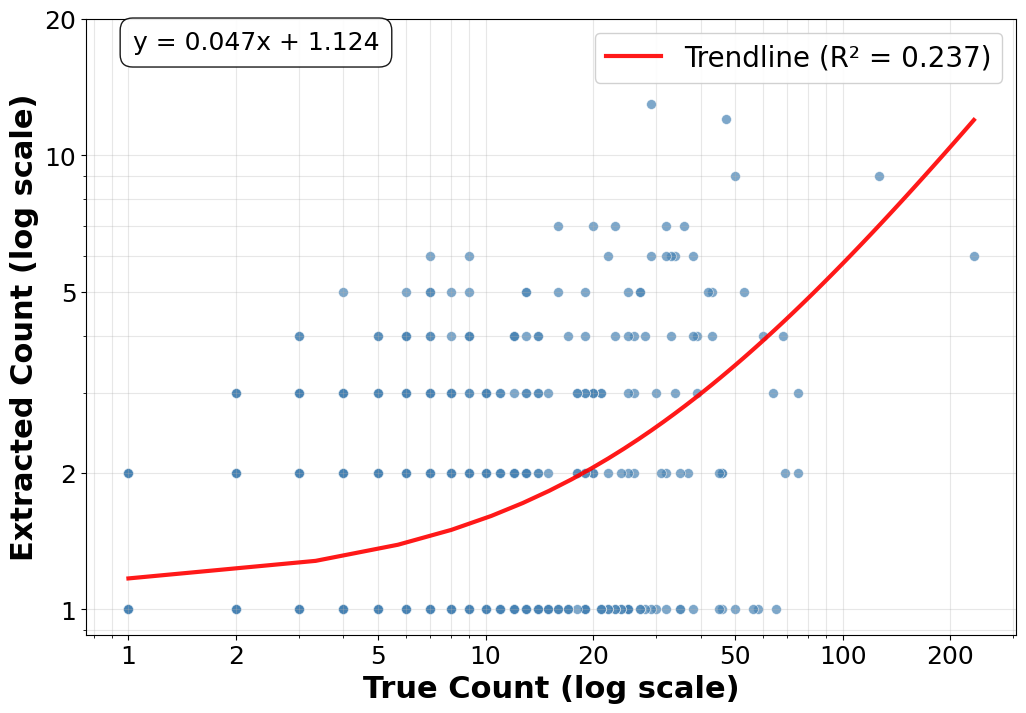

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import FuncFormatter

def clean_log_formatter(x, pos):
    """Custom formatter for log scale to show clean integer labels"""
    if x >= 1:
        return f'{int(x)}'
    else:
        return f'{x:.1f}'

for file, counts_df in results_dataframes.items():
    # Skip if no valid data points
    if len(counts_df) == 0:
        print(f"No valid data points for {file}, skipping...")
        continue
    
    # Remove the most extreme outlier for better visualization
    if counts_df['extracted_count'].max() > 1000:
        counts_df = counts_df[counts_df['extracted_count'] < counts_df['extracted_count'].max()]

    plt.figure(figsize=(12, 8))
    plt.scatter(counts_df['true_count'], counts_df['extracted_count'], alpha=0.7, s=50, 
                color='steelblue', edgecolors='white', linewidth=0.5)
    
    # Add trendline with R² score only if we have enough data points
    if len(counts_df) >= 2:
        # Fit linear regression
        X = counts_df['true_count'].values.reshape(-1, 1)
        y = counts_df['extracted_count'].values
        
        # Check for any remaining NaN values
        if not np.isnan(X).any() and not np.isnan(y).any():
            reg = LinearRegression().fit(X, y)
            y_pred = reg.predict(X)
            r2 = r2_score(y, y_pred)
            
            # Plot trendline - make it more visible
            x_trend = np.linspace(counts_df['true_count'].min(), counts_df['true_count'].max(), 100)
            y_trend = reg.predict(x_trend.reshape(-1, 1))
            plt.plot(x_trend, y_trend, 'red', linewidth=3, alpha=0.9, 
                     label=f'Trendline (R² = {r2:.3f})')
            
            # Add equation text with better positioning
            slope = reg.coef_[0]
            intercept = reg.intercept_
            plt.text(0.05, 0.95, f'y = {slope:.3f}x + {intercept:.3f}', 
                     transform=plt.gca().transAxes, fontsize=18, 
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, pad=0.5))
            
            plt.legend(fontsize=20, framealpha=0.9)
        else:
            print(f"Warning: NaN values detected in data for {file}")
    else:
        print(f"Insufficient data points for trendline in {file} (n={len(counts_df)})")
    
    # Set log scale for better visibility
    plt.xscale('log')
    plt.yscale('log')
    
    # Customize the tick formatters to show clean labels
    ax = plt.gca()
    ax.xaxis.set_major_formatter(FuncFormatter(clean_log_formatter))
    ax.yaxis.set_major_formatter(FuncFormatter(clean_log_formatter))
    
    # Force specific tick locations for cleaner appearance
    x_ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
    y_ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
    
    # Filter ticks to only show those within data range
    x_min, x_max = counts_df['true_count'].min(), counts_df['true_count'].max()
    y_min, y_max = counts_df['extracted_count'].min(), counts_df['extracted_count'].max()
    
    x_ticks_filtered = [t for t in x_ticks if x_min <= t <= x_max * 2]
    y_ticks_filtered = [t for t in y_ticks if y_min <= t <= y_max * 2]
    
    if x_ticks_filtered:
        ax.set_xticks(x_ticks_filtered)
    if y_ticks_filtered:
        ax.set_yticks(y_ticks_filtered)
    
    # Increase axis label sizes
    plt.xlabel('True Count (log scale)', fontsize=22, fontweight='bold')
    plt.ylabel('Extracted Count (log scale)', fontsize=22, fontweight='bold')
    
    # Increase tick label sizes
    plt.tick_params(axis='both', which='major', labelsize=18)
    
    # Remove title as requested
    
    plt.grid(True, alpha=0.3, which='both')
    
    # Save as png
    # plt.savefig(file.split("_queries=")[0].split("true-pref_")[1] + '_loglog.png', dpi=300, bbox_inches='tight')
    plt.savefig('correlation_PII-extraction.pdf', format='pdf', bbox_inches='tight')
    plt.show()